In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [3]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool # 랭체인 제공 도구

market_research_tools = [YahooFinanceNewsTool()]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import MessagesPlaceholder # 대화 기록을 위한 Placeholder

# 에이전트의 역할을 정의하는 SystemMessage 인스턴스 생성
system_message_content = (
    "You are a professional market researcher. "
    "Your primary goal is to gather information and provide **fact-based answers only**, "
    "avoiding personal opinions or speculative analysis. "
    "You must use the provided tools to retrieve data when necessary."
)
system_message = SystemMessage(content=system_message_content)

# ChatPromptTemplate은 리스트 형태의 메시지 템플릿을 받습니다.
custom_prompt = ChatPromptTemplate.from_messages(
    [
        system_message,                      # SystemMessage 객체 자체를 리스트에 포함
        MessagesPlaceholder(variable_name="messages"), # 대화 기록을 위한 Placeholder
    ]
)

# 시장 조사 에이전트를 생성합니다.
market_research_agent = create_react_agent(
    model=llm, 
    tools=market_research_tools, 
    prompt=custom_prompt # 수정: custom_prompt 사용
)

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node입니다. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = market_research_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
        goto='supervisor'
    )

In [6]:
import yfinance as yf

from langchain.tools import tool

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past month"""
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info


stock_research_tools = [get_stock_price]

In [10]:
@tool
def get_stock_price(ticker: str) -> dict:
    """주식 티커를 받아 지난 한 달간의 가격 데이터를 딕셔너리 형태로 반환합니다."""
    # yf.download는 데이터를 DataFrame으로 반환하므로 .to_dict()로 변환합니다.
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info

stock_research_tools = [get_stock_price]

# 에이전트의 역할을 정의하는 SystemMessage 인스턴스 생성
system_message_content = (
    "You are an expert financial and stock researcher. "
    "Your task is to utilize the 'get_stock_price' tool to fetch stock data. "
    "Provide analysis and answers **based on the retrieved facts and data only**. "
    "Do not offer investment advice, opinions, or speculative forecasts."
)
system_message = SystemMessage(content=system_message_content)

# ChatPromptTemplate 구성
custom_prompt = ChatPromptTemplate.from_messages(
    [
        system_message,
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# 주식 조사 에이전트를 생성합니다. (state_modifier 제거 및 prompt 인자 사용)
stock_research_agent = create_react_agent(
    model=llm, 
    tools=stock_research_tools, 
    prompt=custom_prompt # 수정: 사용자 지정 프롬프트 사용
)

def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node입니다. 주어진 State를 기반으로 주식 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    result = stock_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor'
    )

In [7]:
@tool
def company_research_tool(ticker: str) -> dict:
    """Given a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    return {
        'financial_info': financial_info,
        'sec_filings': sec_filings
    }

company_research_tools = [company_research_tool]

# 에이전트의 역할을 정의하는 SystemMessage 인스턴스 생성
system_message_content = (
    "You are an expert company researcher. "
    "Your primary goal is to use the 'company_research_tool' to fetch and summarize "
    "corporate financial information and SEC filings for the given ticker. "
    "You must provide answers **based on the retrieved facts and data only** "
    "and should not offer any personal opinions or speculative commentary."
)
system_message = SystemMessage(content=system_message_content)

# ChatPromptTemplate 구성
custom_prompt = ChatPromptTemplate.from_messages(
    [
        system_message,
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# 회사 조사 에이전트를 생성합니다. (state_modifier 제거 및 prompt 인자 사용)
company_research_agent = create_react_agent(
    model=llm, 
    tools=company_research_tools, 
    prompt=custom_prompt # 수정: 사용자 지정 프롬프트 사용
)

def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 조사 node입니다. 주어진 State를 기반으로 회사 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    result = company_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='company_research')]},
        goto='supervisor'
    )

In [8]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Important Instruction: **Your final answer MUST be in KOREAN (한글) and should only contain the final decision (매수, 매도, 또는 보유) and a brief, professional justification.**

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    """
    분석가 node입니다. 주어진 State를 기반으로 분석가 체인을 호출하고,
    결과 메시지를 반환합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환합니다.
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [9]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node입니다. 주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정합니다. 모든 작업이 완료되면 analyst node로 이동합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령을 반환합니다.
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [11]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)

In [12]:
graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()

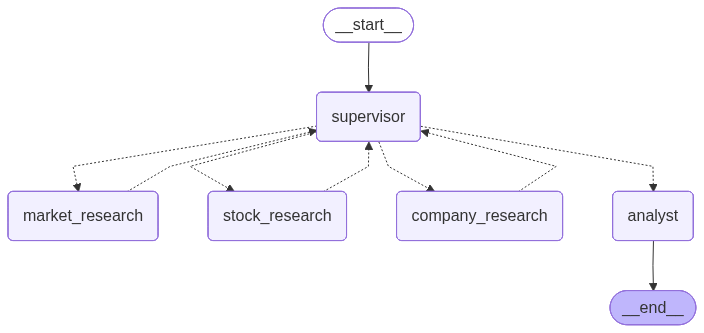

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass